# Visualizing embeddings with t-SNE

In this notebook, I used t-SNE algorithm to visualize embeddings. This is a nice technique to understand the nature of your embeddings.

**t-SNE:**

Visualizing data in 1 or 2 dimensions is easy - but it's not clear how to visualize embeddings which are 8-dimensional. t-SNE is a dimensionality reduction algorithm which is often used for visualization. It learns a mapping from a set of high-dimensional vectors, to a space with a smaller number of dimensions (usually 2), which is hopefully a good representation of the high-dimensional space.

What makes a mapping a "good representation": t-SNE tries to make sure that if high-dimensional vectors  u and  v  are close together, then  map(u)  and  map(v)  are close together in the 2-d mapping space.

One practical application of visualizing trained embeddings with t-SNE is understanding what information about the embedded entities our model has (and hasn't) learned. This can give us some intuition about how our model works, what latent features it thinks are useful, whether adding certain additional data explicitly might improve the model's accuracy, and so on.

In the code cells below we briefly explore questions like **whether our embeddings were sensitive to genre**, and also identify patterns in our 2-d embedding space when we group or filter by some other movie metadata.

To get started, run the code cell below to import the necessary libraries, and load a copy of the t-SNE mapping we learned in the lesson.

In [1]:
%matplotlib inline
import random
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras


model = keras.models.load_model('best_model.h5')

# model.compile(keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
#     loss='MSE',
#     metrics=['MAE'],
# )

emb_layer = model.get_layer('movie_embedding')
(w,) = emb_layer.get_weights()

movies_df = pd.read_csv('movies.csv')
movies_df.head()

Using TensorFlow backend.


movieId                        title  \
0        0                    Toy Story   
1        1                      Jumanji   
2        2             Grumpier Old Men   
3        3            Waiting to Exhale   
4        4  Father of the Bride Part II   

                                        genres  year  \
0  Adventure|Animation|Children|Comedy|Fantasy  1995   
1                   Adventure|Children|Fantasy  1995   
2                               Comedy|Romance  1995   
3                         Comedy|Drama|Romance  1995   
4                                       Comedy  1995   

                           key  n_ratings  mean_rating  
0                    Toy Story      49695     3.921240  
1                      Jumanji      22243     3.211977  
2             Grumpier Old Men      12735     3.151040  
3            Waiting to Exhale       2756     2.861393  
4  Father of the Bride Part II      12161     3.064592

We saw that our dataset has lots of obscure movies with few ratings (sometimes as few as one). We know so little about these movies that their embeddings are as good as random. We can clarify our visualization by selecting only movies that meet some popularity threshold.

In [2]:
threshold = 100
movies = movies_df[movies_df.n_ratings >= threshold].reset_index(drop=True)
print("Went from {} to {} movies after applying threshold".format(
    len(movies_df), len(movies),
))
w_full = w
w = w[movies.movieId]
df = movies

Went from 26744 to 8546 movies after applying threshold


In [3]:
""" We'll be using scikit-learn's t-SNE implementation.
    t-SNE uses euclidean distance. But because cosine distance is known to work well on embeddings, 
    we'll pass in metric="cosine" when creating the model."""

from sklearn.manifold import TSNE

# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

embs = tsne.fit_transform(w)
# Add to dataframe for convenience
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]

## 1. We see whether our embeddings were sensitive to genre

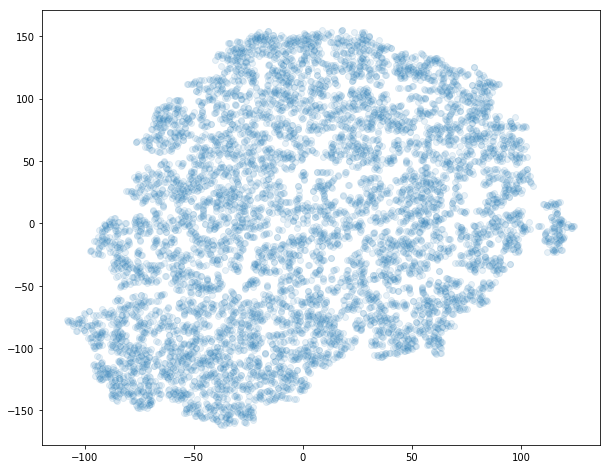

In [4]:
# First, let's use matplotlib to draw a scatter plot of our movies, using our new 2-d mapping.

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df.x, df.y, alpha=.1);

It's hard to judge by the shape alone. A good **sanity check** is to identify some groups of movies that we strongly believe should be close together, and see whether they're close in the 2-d space.

For example, all the Harry Potter movies should be close together, right?

In [11]:
# Some helper functions for plotting annotated t-SNE visualizations

# TODO: adjust_text not available in kernels
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

def adjust_text(*args, **kwargs):
    pass

def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def annotate_sample(n, n_ratings_thresh=0):
    """Plot our embeddings with a random sample of n movies annotated.
    Only selects movies where the number of ratings is at least n_ratings_thresh.
    """
    sample = mainstream_movies[mainstream_movies.n_ratings >= n_ratings_thresh].sample(
        n, random_state=1)
    plot_with_annotations(sample.index)

def plot_by_title_pattern(pattern, **kwargs):
    """Plot all movies whose titles match the given regex pattern.
    """
    match = df[df.title.str.contains(pattern)]
    return plot_with_annotations(match.index, **kwargs)

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    if emb_2d is None:
        emb_2d = embs
    X = emb_2d[label_indices, 0]
    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    if text:
        # TODO: Add abbreviated title column
        titles = mainstream_movies.loc[label_indices, 'title'].values
        texts = []
        for label, x, y in zip(titles, Xlabeled, Ylabeled):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, 
                    #expand_text=(1.01, 1.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                   )
    return ax

FS = (13, 9)
def plot_region(x0, x1, y0, y1, text=True):
    """Plot the region of the mapping space bounded by the given x and y limits.
    """
    fig, ax = plt.subplots(figsize=FS)
    pts = df[
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:
        texts = []
        for label, x, y in zip(pts.title.values, pts.x.values, pts.y.values):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, expand_text=(1.01, 1.05))
    return ax

def plot_region_around(title, margin=5, **kwargs):
    """Plot the region of the mapping space in the neighbourhood of the the movie with
    the given title. The margin parameter controls the size of the neighbourhood around
    the movie.
    """
    xmargin = ymargin = margin
    match = df[df.title == title]
    assert len(match) == 1
    row = match.iloc[0]
    return plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)

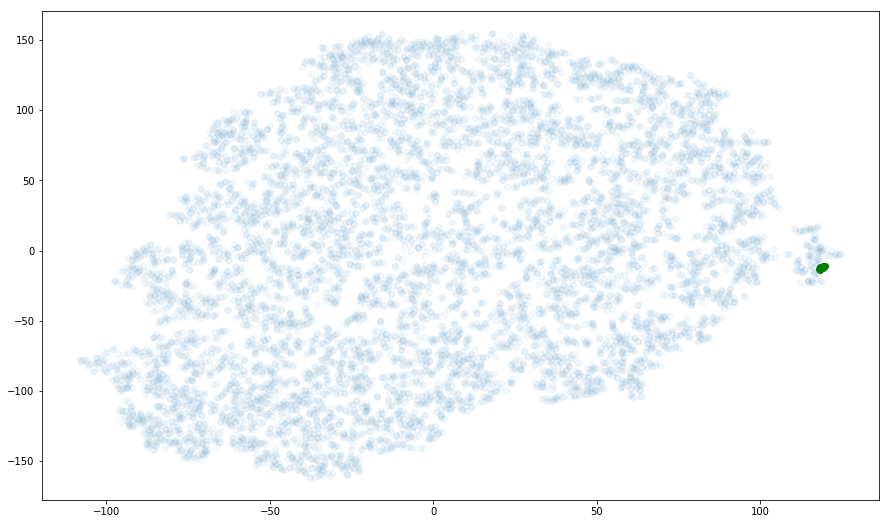

In [24]:
# This and several other helper functions are defined in a code cell above. Hit the "code"
# button above if you're curious about how they're implemented.
plot_by_title_pattern('Harry Potter', figsize=(15, 9), bg_alpha=.05, text=False);

The plot above has a green dot for each of the 8 Harry Potter movies - but they're so close together, they're impossible to distinguish at this scale. That's a good sign!

Let's zoom in to get a closer look.



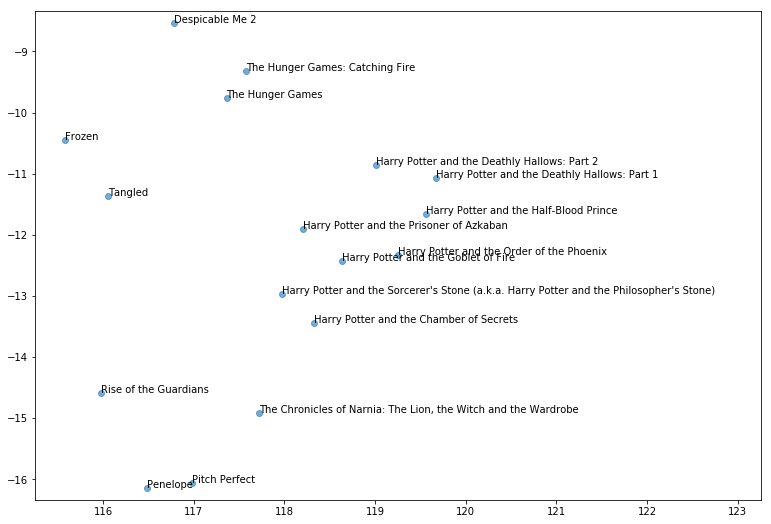

In [9]:
plot_region_around('Harry Potter and the Order of the Phoenix', 4);

Not only are the Harry Potter movies tightly clustered, they're arranged roughly in order of release!




### Local vs. Global structure
One of the key features of t-SNE which makes it so good for visualization is that it's good at capturing clusters at multiple scales. We've seen that our mapping is successfully capturing small, tight, local structures. What about bigger structures encompassing more loosely related movies?

We've already seen a small example of this above: the closest neighbours to the Harry Potter movies are movies from the Hunger Games series - another set of movies based on a series of young adult fantasy books. Makes sense!

What about less niche genres? Where do documentaries fall?

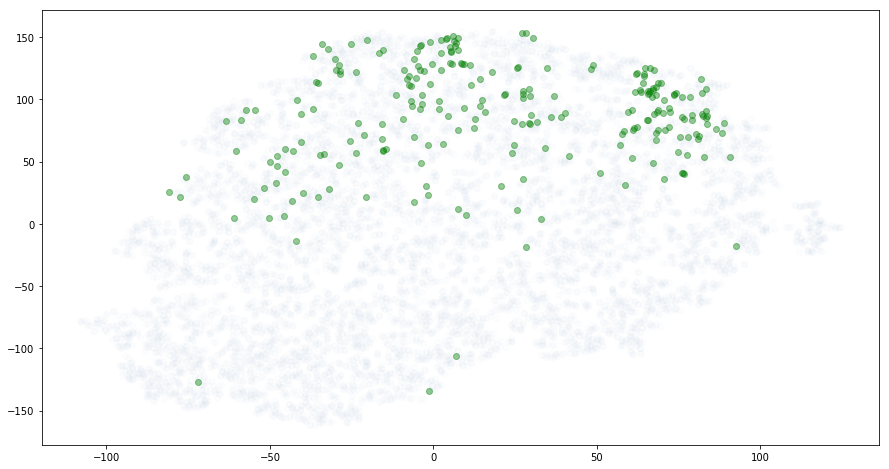

In [10]:
docs = df[ (df.genres == 'Documentary') ]
plot_with_annotations(docs.index, text=False, alpha=.4, figsize=(15, 8));

Nice! It's not a tight cluster, but there's definitely a strong pattern here.

And just to reiterate: we never actually showed the model genre as a feature. It can't read the titles to see that Harry Potter and the Philosopher's Stone and Harry Potter and the Chamber of Secrets belong to the same series. It managed to pick up these latent patterns and incorporate them into the embedding space just by seeing data points like "user 5299 gave movie 806 a rating of 4.5". Pretty impressive!

Here's another, slightly more complicated genre experiment: visualizing all movies whose genres are a subset of {Comedy, Drama, Romance} (i.e. comedies, dramas, romances, dramedies, romantic dramas, romcoms, and... "dromcoms")

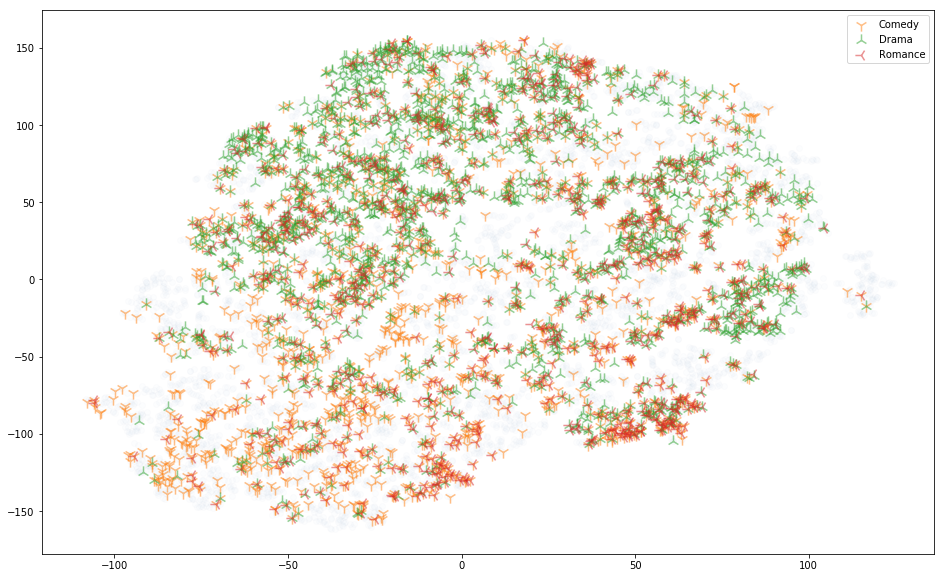

In [12]:
import itertools
sample_rate = 1
genre_components = ['Comedy', 'Drama', 'Romance']
genre_combos = set()
for size in range(1, 4):
    combo_strs = ['|'.join(genres) for genres in itertools.combinations(genre_components, size)]
    genre_combos.update(combo_strs)

ax = plot_bg(figsize=(16, 10))
dromcoms = df[df.genres.isin(genre_combos)]
if sample_rate != 1:
    dromcoms = dromcoms.sample(frac=sample_rate, random_state=1)
for i, genre in enumerate(genre_components):
    m = dromcoms[dromcoms.genres.str.contains(genre)]
    marker = str(i+1)
    add_annotations(ax, m.index, label=genre, alpha=.5, marker=marker, s=150, linewidths=5)
plt.legend();

This is an awesome example of structure at the largest scale. Dramas are mostly in the upper-right half, and comedies are mostly in the other half (with romances having a more spread-out, bursty distribution).

# 1. Release year

Are our movie embeddings sensitive to year? 

The code cell below shows how we can use the `c` keyword arg of [`Axes.scatter`](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html) to specify a color for each point of a scatter plot. Right now, we're graphing the positions of our movie embeddings (after t-SNE dimensionality reduction) and assigning color randomly.

A movie's point is colored according to its year of release.

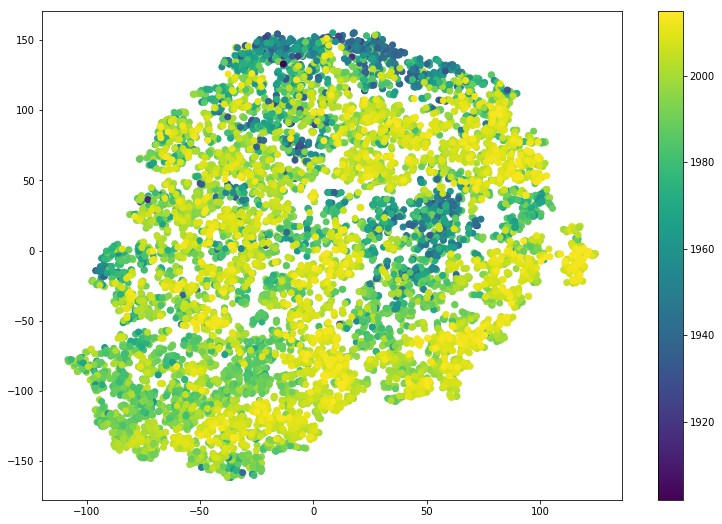

In [19]:
import matplotlib
FS = (13, 9)
fig, ax = plt.subplots(figsize=FS)

c = df.year

pts = ax.scatter(df.x, df.y, c=c)

cbar = fig.colorbar(pts)


Is there a global pattern to year of release in our t-SNE mapping? i.e. is it possible to draw a straight line through our embeddings such that year tends to increase as we move in that direction? 

- We try to experiment with different color maps, using the `cmap` keyword argument of `scatter` method. https://matplotlib.org/examples/color/colormaps_reference.html gives reference to use different colormaps. But we need to check whether different colormaps offer different insights into the data, but if you use one of the "qualitative colormaps" we could see observable changes.




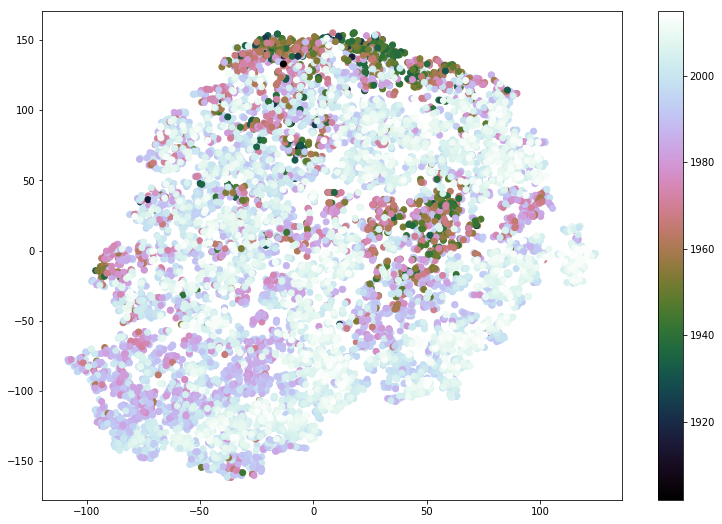

In [22]:

"""Using a colormap that passes through several hues (such as 'brg', or 'cubehelix') 
can make it easier to identify regions associated with specific eras:"""

FS = (13, 9)
fig, ax = plt.subplots(figsize=FS)

pts = ax.scatter(df.x, df.y, c=c, cmap='cubehelix')

cbar = fig.colorbar(pts)

- By default, the smallest and largest numerical values in the data are mapped to the extremes of our colormap. In the case of year, the earliest movie in our dataset is from 1902, but there are very few movies in the first few decades of the 20th century. Would our results be easier to interpret if we started our colormap at 1930 or 1940? Give it a try. Hint: check out the `norm` argument to [`ax.scatter`](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html) and the documentation for [`matplotlib.colors.Normalize`]
(https://matplotlib.org/api/_as_gen/matplotlib.colors.Normalize.html#matplotlib.colors.Normalize).



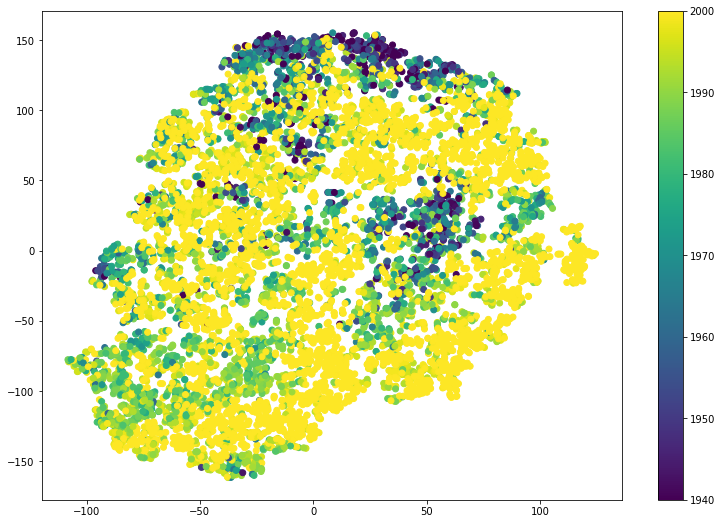

In [23]:
FS = (13, 9)
fig, ax = plt.subplots(figsize=FS)

pts = ax.scatter(df.x, df.y, c=c, norm = matplotlib.colors.Normalize(vmin=1940, vmax=2000, clip=False))

cbar = fig.colorbar(pts)


The distribution of year of release does seem to follow some distinct gradients, but the pattern is not global.


# 2. Average rating

This is a very salient question for our problem of predicting user-assigned ratings. Does a movie's "goodness" or "badness", as measured by its average user rating, manifest in its embedding? 

We shall see that by creating a scatter plot of our movie embeddings where a movie's color is set according to its mean rating. To check whether there is a global pattern to the distribution of mean rating?

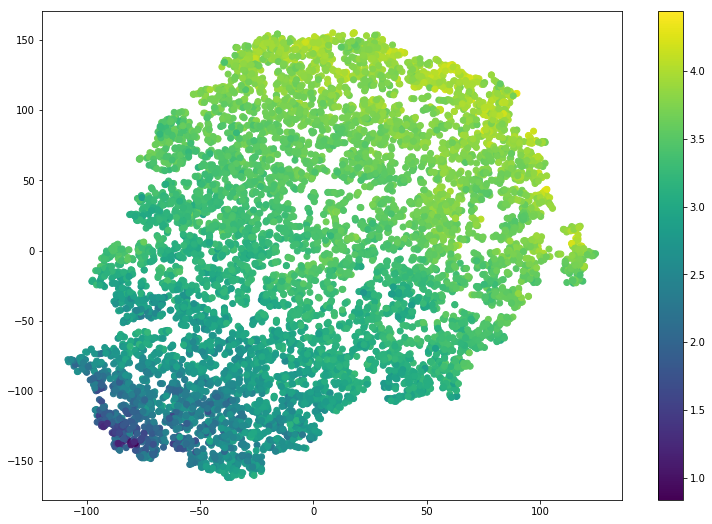

In [25]:
# Your code goes here

import matplotlib
FS = (13, 9)
fig, ax = plt.subplots(figsize=FS)

c = df.mean_rating
pts = ax.scatter(df.x, df.y, c=c) #norm = matplotlib.colors.Normalize(vmin=1940, vmax=2000, clip=False))

cbar = fig.colorbar(pts)

Unlike with year of release, there seems to be a clear global pattern here: average rating tends to increase moving from left to right.

 # 3. Number of ratings
 
Some movies are divisive - you either love them, or you hate them. Is this reflected in our embeddings? we'll see how 'spread out' the user ratings are for each movie. Do our embeddings reflect the number of ratings we have in the dataset for each movie? (We might think of this as a proxy for how popular or obscure a movie is.)

In the code cell below we use color to represent number of ratings

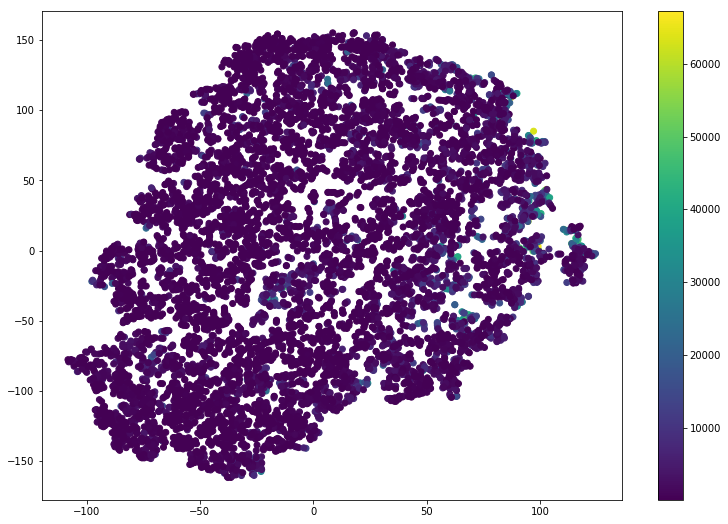

In [39]:
fig, ax = plt.subplots(figsize=FS)

c = df.n_ratings

pts = ax.scatter(df.x, df.y, c=c)

cbar = fig.colorbar(pts)

This is pretty hard to read. Most of our movies have on the order of hundreds of ratings, but there's also a long tail of movies with tends of thousands of ratings, which makes a linear scale a poor choice. 

We try improving the visualization above to help us answer our question: are our embeddings sensitive to number of ratings?

by using different normalizations, `norm` argument to [`ax.scatter`](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html) and the documentation for [`matplotlib.colors.Normalize`]
(https://matplotlib.org/api/_as_gen/matplotlib.colors.Normalize.html#matplotlib.colors.Normalize).



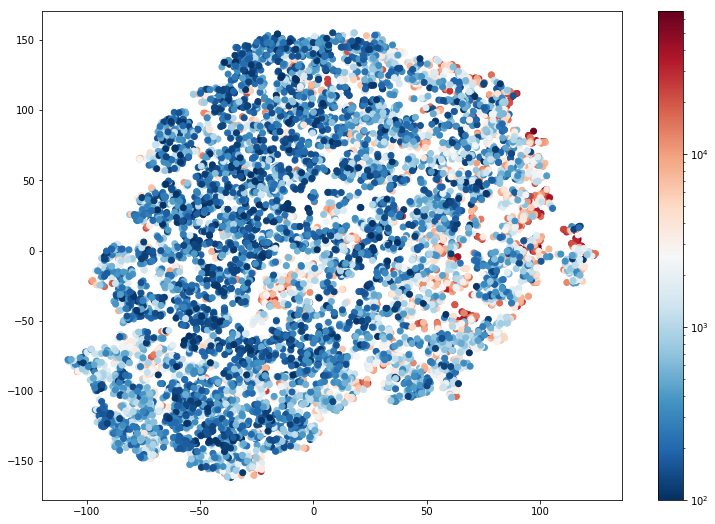

In [50]:
# Using Log normalization

fig, ax = plt.subplots(figsize=FS)

c = df.n_ratings

pts = ax.scatter(df.x, df.y, c=c, norm=matplotlib.colors.LogNorm(), cmap='RdBu_r')

cbar = fig.colorbar(pts)

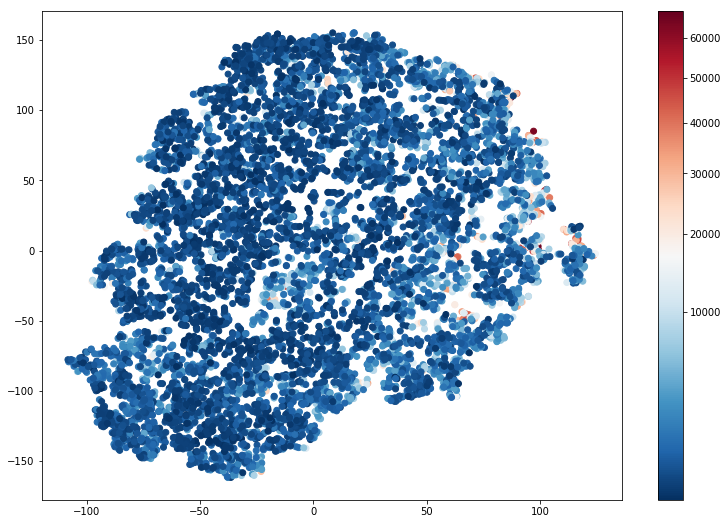

In [59]:
# Using power normalization

fig, ax = plt.subplots(figsize=FS)

c = df.n_ratings

pts = ax.scatter(df.x, df.y, c=c, norm=matplotlib.colors.PowerNorm(gamma=0.5), cmap='RdBu_r')

cbar = fig.colorbar(pts)

With number of ratings I don't see any pattern either local or global. It seems that there are large number of ratings given by he user below 10k but still you can see the higher number of ratings is not either in a pattern from left to right or right to left. 

Different types of "norm" normalizations also seems like doesn't catch any pattern. Hence we conclude that our embeddings are not much sensitive to the number of ratings.

I am stopping here my visualization of embeddings but we could do many more like visualizing one or more variables you find by joining our MovieLens dataset with other movie datasets. For example, [imdb-data](https://www.kaggle.com/PromptCloudHQ/imdb-data) has some interesting features we're missing including box office revenue, runtime, and director.
